<a href="https://colab.research.google.com/github/bsttiv/tipos_espectrales/blob/main/Tipos_Espectrales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Limpieza de los datos

In [1]:
# Se monta el drive para cargar los datos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Se importa pandas para procesar los datos
import pandas as pd
import numpy as np

In [3]:
# Tipos espectrales en los q estamos interesados
tipos_espectrales = ["O", "B", "A", "F", "G", "K", "M"]

In [4]:
# Funciones que se usan en el parámetro converters del método read_csv
# Su objetivo es filtrar los datos y eliminar aquellos que no estén en el formato correcto

def texto_a_float(texto):
  try:
    return np.float64(texto.strip())
  except Exception:
    return np.nan

def texto_mayuscula_primera_letra(texto):
  try:
    return texto.strip().upper()[0]
  except Exception:
    return "NaN"

In [5]:
# Ruta de la base de datos
ruta = "drive/MyDrive/Modulo/Tipos_Espectrales/hip_main.dat"
# Nombres de las columnas (según la especificación de https://heasarc.gsfc.nasa.gov/w3browse/all/hipparcos.html)
names = ["H"+str(i) for i in range(0, 78)]
# Se lee la base de datos con los parámetros adecuados
df = pd.read_csv(ruta, sep="|", converters={"H76": texto_mayuscula_primera_letra, "H32": texto_a_float, "H37": texto_a_float, "H40": texto_a_float}, names=names, keep_default_na=False)
# Se eliminan aquellas filas cuyo tipo espectral no coincida con los buscados (O, B, A, F, G, K, M)
df = df[df["H76"].isin(tipos_espectrales)]
# Se borran las columnas que no se usarán
labels = ["H"+str(i) for i in range(0, 78) if i not in [76, 32, 37, 40]]
df.drop(labels=labels, inplace=True, axis=1)
# Se eliminan todas las filas que posiblemente no tengan valores definidos
df.dropna(axis=0, inplace=True)
# Se muestra el DataFrame
df

<ipython-input-5-3a6df1d0f274>:6: DtypeWarning: Columns (5,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta, sep="|", converters={"H76": texto_mayuscula_primera_letra, "H32": texto_a_float, "H37": texto_a_float, "H40": texto_a_float}, names=names, keep_default_na=False)
<ipython-input-5-3a6df1d0f274>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(labels=labels, inplace=True, axis=1)
<ipython-input-5-3a6df1d0f274>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=0, inplace=True)


,H32,H37,H40,H76
0,9.643,0.482,0.55,F
1,10.519,0.999,1.04,K
2,6.576,-0.019,0.00,B
3,8.471,0.370,0.43,F
4,9.693,0.902,0.90,G
...,...,...,...,...
118213,9.107,1.595,1.61,K
118214,9.019,0.639,0.70,G
118215,8.868,0.999,0.98,K
118216,10.077,0.698,0.75,G


In [6]:
# Se extraen las filas de cada tipo espectral para posteriormente usar el método describe
# Y visualizar las estadísticas de los datos

df_tipo_o = df[df["H76"] == "O"]
df_tipo_b = df[df["H76"] == "B"]
df_tipo_a = df[df["H76"] == "A"]
df_tipo_f = df[df["H76"] == "F"]
df_tipo_g = df[df["H76"] == "G"]
df_tipo_k = df[df["H76"] == "K"]
df_tipo_m = df[df["H76"] == "M"]

In [7]:
df_tipo_o.describe()

,H32,H37,H40
count,255.000000,255.000000,255.000000
mean,8.008573,0.222824,0.258627
std,1.822831,0.302070,0.317725
min,1.566000,-0.335000,-0.370000
25%,7.060000,0.009000,0.030000
50%,8.176000,0.169000,0.180000
75%,9.246500,0.405000,0.480000
max,11.624000,1.408000,1.390000


In [8]:
df_tipo_b.describe()

,H32,H37,H40
count,10341.000000,10341.000000,10341.000000
mean,7.843250,0.046298,0.067571
std,1.489189,0.187834,0.199207
min,0.312000,-0.400000,-0.420000
25%,7.008000,-0.066000,-0.040000
50%,7.986000,-0.004000,0.020000
75%,8.846000,0.101000,0.110000
max,12.843000,1.910000,2.480000


In [9]:
df_tipo_a.describe()

,H32,H37,H40
count,18550.000000,18550.000000,18550.000000
mean,8.230618,0.179759,0.205729
std,1.209015,0.147032,0.158022
min,1.248000,-0.400000,-0.290000
25%,7.582000,0.075000,0.090000
50%,8.350000,0.170000,0.190000
75%,9.025000,0.267000,0.300000
max,11.934000,1.745000,2.160000


In [10]:
df_tipo_f.describe()

,H32,H37,H40
count,25306.000000,25306.000000,25306.000000
mean,9.071121,0.476358,0.542513
std,1.158848,0.117243,0.116609
min,-0.417000,-0.400000,-0.160000
25%,8.407000,0.408000,0.480000
50%,9.132000,0.472000,0.540000
75%,9.845000,0.530000,0.600000
max,12.839000,2.180000,2.780000


In [11]:
df_tipo_g.describe()

,H32,H37,H40
count,22409.000000,22409.000000,22409.000000
mean,9.536064,0.787254,0.817905
std,1.075112,0.206393,0.171363
min,3.418000,-0.400000,-0.100000
25%,8.977000,0.624000,0.690000
50%,9.656000,0.740000,0.790000
75%,10.240000,0.955000,0.950000
max,12.869000,2.215000,2.960000


In [12]:
df_tipo_k.describe()

,H32,H37,H40
count,31378.000000,31378.000000,31378.000000
mean,9.710005,1.202528,1.193795
std,1.124681,0.233951,0.247679
min,1.629000,-0.400000,-0.060000
25%,9.081000,1.040000,1.020000
50%,9.850500,1.165000,1.130000
75%,10.456000,1.365000,1.350000
max,13.130000,2.867000,3.510000


In [13]:
df_tipo_m.describe()

,H32,H37,H40
count,4148.000000,4148.000000,4148.000000
mean,10.171799,1.561587,2.269812
std,1.352534,0.209219,0.684430
min,2.849000,0.000000,0.010000
25%,9.362000,1.483000,1.840000
50%,10.350500,1.589000,2.150000
75%,11.130500,1.659000,2.560000
max,13.247000,3.315000,5.750000


Los campos a utilizar serán "H32" (que corresponde a magnitud); "H37", "H40" (índices de color); y "H76" (tipo espectral)

https://heasarc.gsfc.nasa.gov/w3browse/all/hipparcos.html

# Visualización de los datos

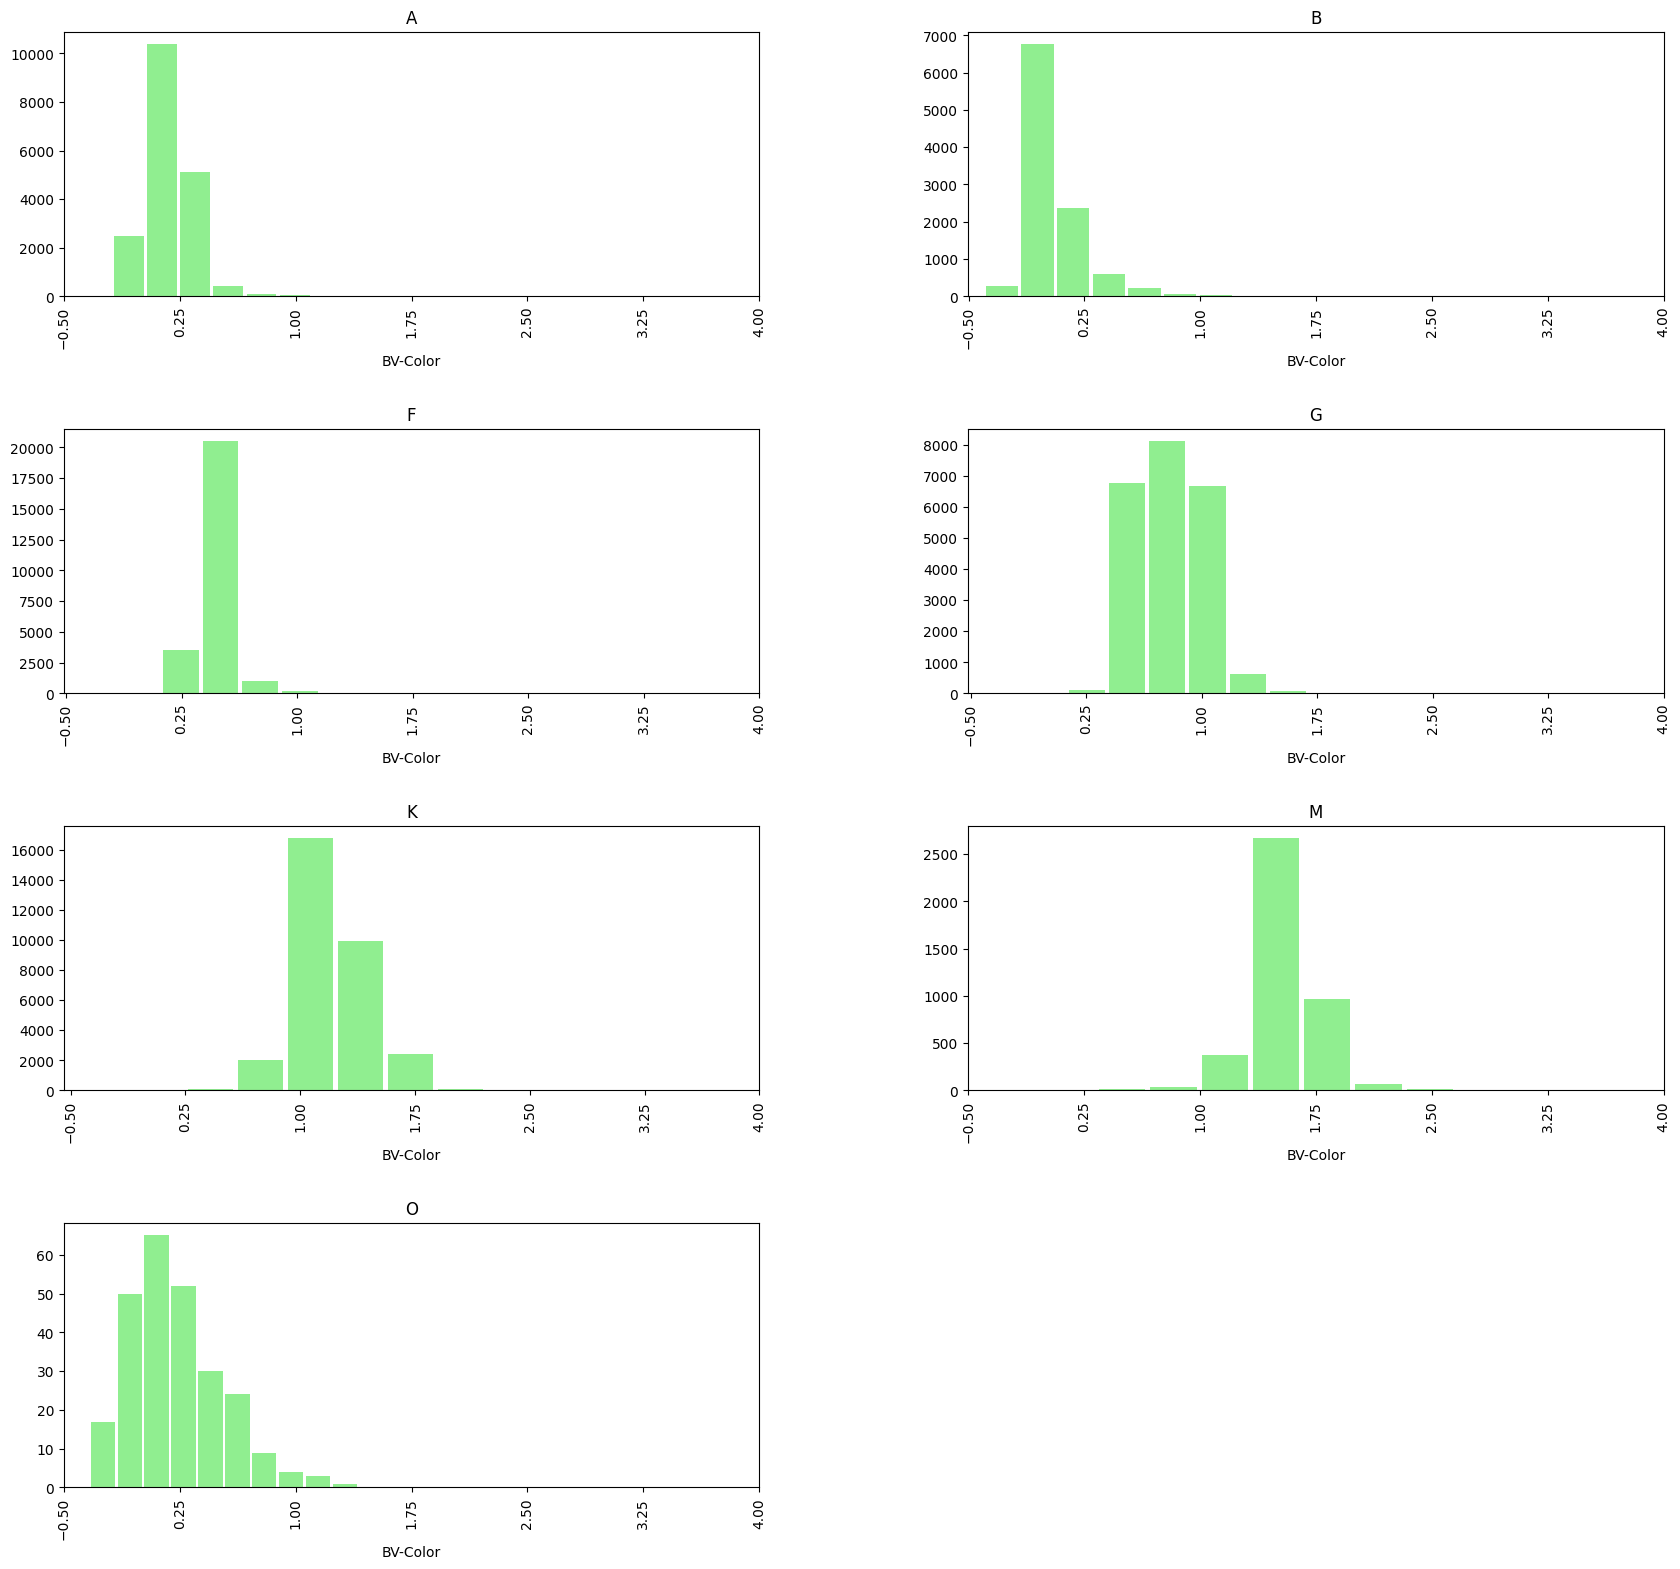

In [14]:
import matplotlib.pyplot as plt

# Histograma BV-Color
ax = df.hist(column="H37", by=df["H76"], figsize=(20,30), layout=(6,2), color='lightgreen', rwidth=0.9)

for row in ax:
  for x in row:
    x.set_xlabel("BV-Color")
    x.set_xticks(np.linspace(-0.5, 4, 7))

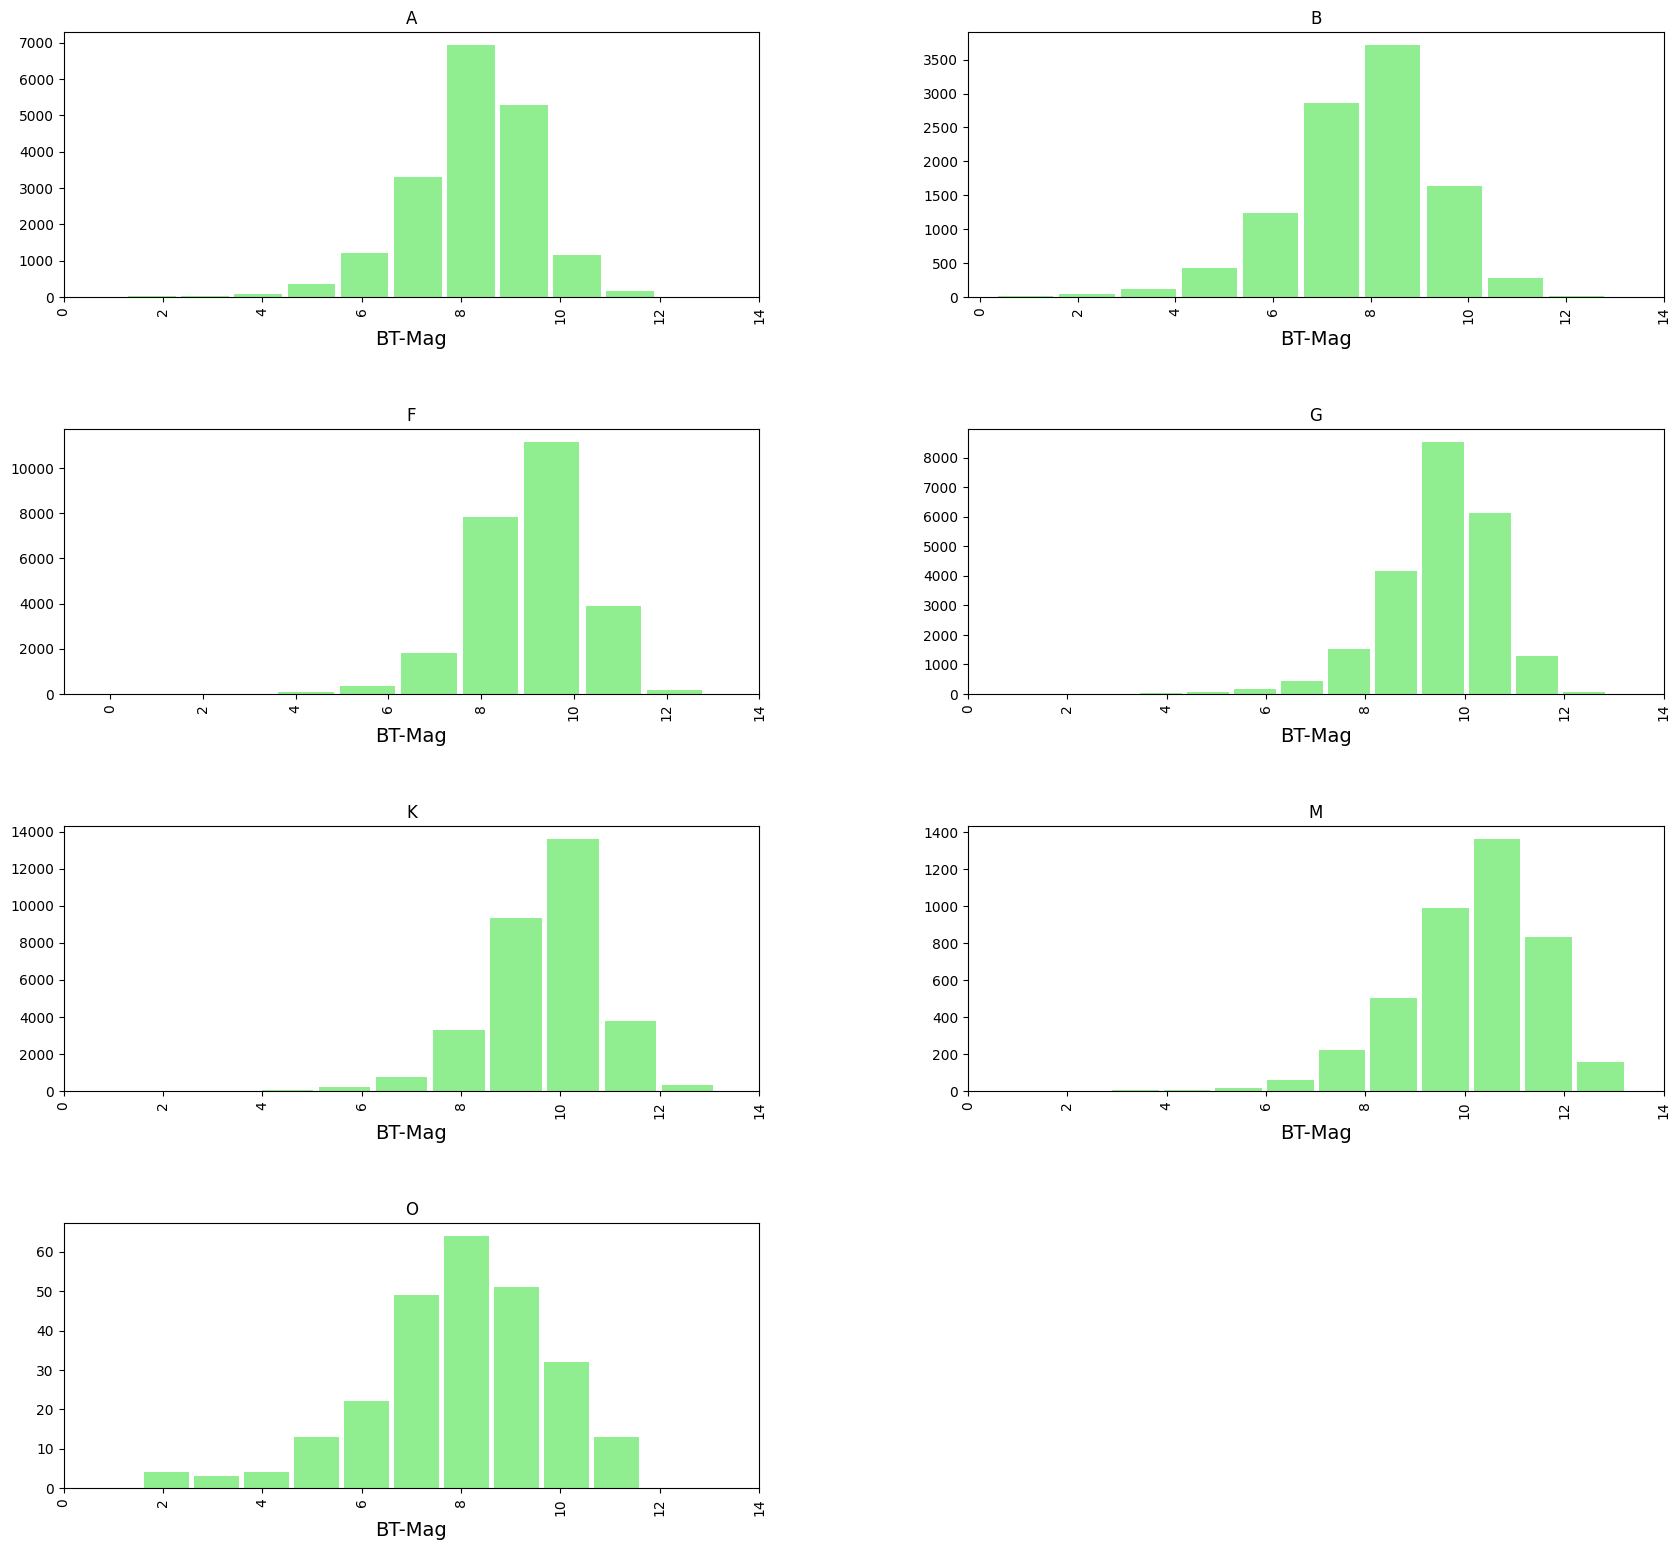

In [15]:
# Histograma BT-Mag
ax = df.hist(column="H32", by=df["H76"], figsize=(20,30), layout=(6,2), color='lightgreen', rwidth=0.9)

for row in ax:
  for x in row:
    x.set_xlabel("BT-Mag", size=14)
    x.set_xticks(range(0, 15, 2))

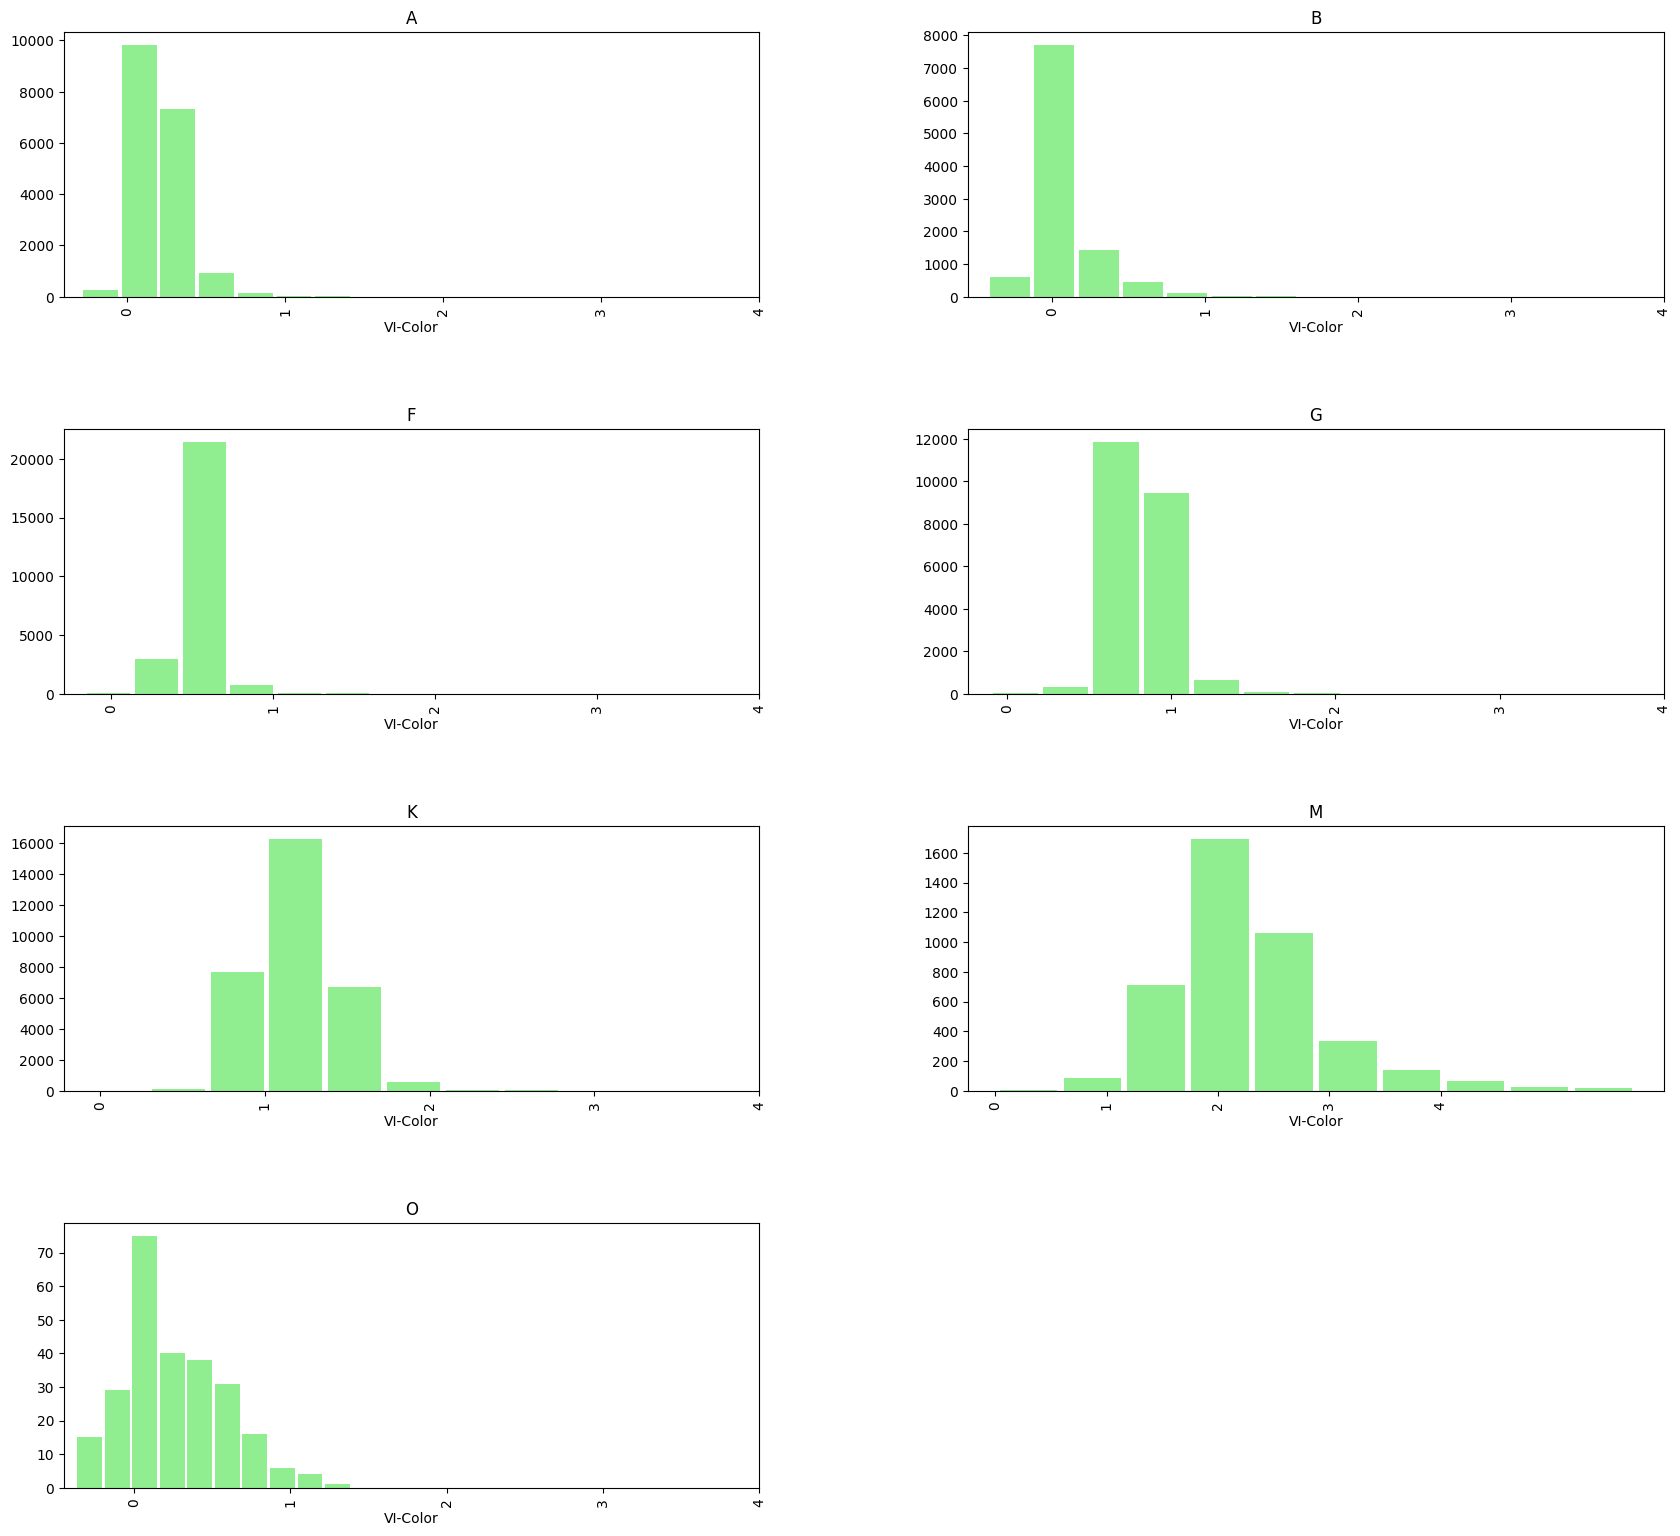

In [16]:
# Histograma VI-Color
ax = df.hist(column="H40", by=df["H76"], figsize=(20,30), layout=(6,2), color='lightgreen', rwidth=0.9)

for row in ax:
  for x in row:
    x.set_xlabel("VI-Color")
    x.set_xticks(np.linspace(0, 4, 5))

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seabo

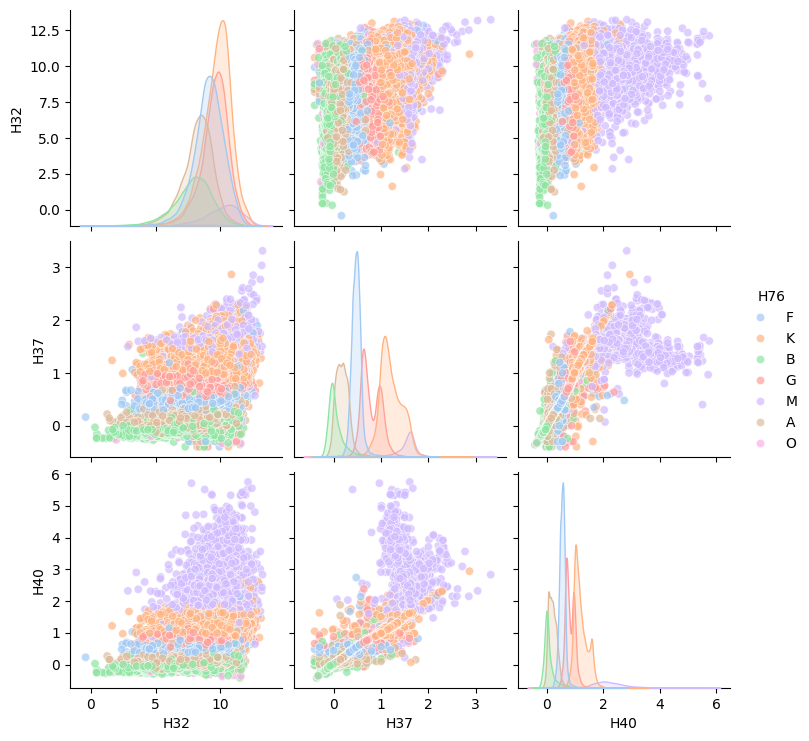

In [17]:
import seaborn as sns

sns.pairplot(df, hue = 'H76', diag_kind = 'kde', palette= sns.color_palette("pastel"), plot_kws=dict(alpha = 0.7),
                   diag_kws=dict(fill=True))

# Modelo: Random Forest

https://youtube.com/watch?v=AYICIq5jnhU&si=3e1M0dp2M4Jl7j5Y

https://www.datacamp.com/tutorial/random-forests-classifier-python

In [59]:
from sklearn.model_selection import train_test_split

columns = ["H32", "H37", "H40"]

x = df.loc[:, columns]
y = df.loc[:, ['H76']]

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=3453, train_size = .25)

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

# Tuning de parametros basado en: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

split = x_train.size/100
params = {  'min_samples_split' : int(split),
            'min_samples_leaf' : int(split/10),
            'max_depth' : 6,
            'max_features' : 'sqrt',
}

random_forest = RandomForestClassifier(**params)

grid_search = GridSearchCV(random_forest, param_grid = { 'n_estimators': range(15, 81, 10) }, n_jobs=4, cv=5)

grid_search.fit(x_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=6, min_samples_leaf=84,
                                              min_samples_split=842),
             n_jobs=4, param_grid={'n_estimators': range(15, 81, 10)})

In [ ]:
print("Precisión en primera etapa de tuneo: ", grid_search.score(x_test, y_test))

In [55]:
params = {
            'min_samples_leaf' : int(split/10),
            'n_estimators' : 65,
            'max_features' : 'sqrt',
}
random_forest = RandomForestClassifier(**params)
grid_search = GridSearchCV(random_forest, param_grid={'max_depth':range(5,20,2), 'min_samples_split':range(200,1001,200)} ,n_jobs=4, cv=5)
grid_search.fit(x_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(min_samples_leaf=84,
                                              n_estimators=65),
             n_jobs=4,
             param_grid={'max_depth': range(5, 20, 2),
                         'min_samples_split': range(200, 1001, 200)})

In [56]:
print("Precisión en segunda etapa de tuneo: ", grid_search.score(x_test, y_test))

0.771577036694309

In [57]:
predicted = grid_search.predict(x_test)

Text(0.5, 1.0, 'Matriz de confusión de Random Forest')

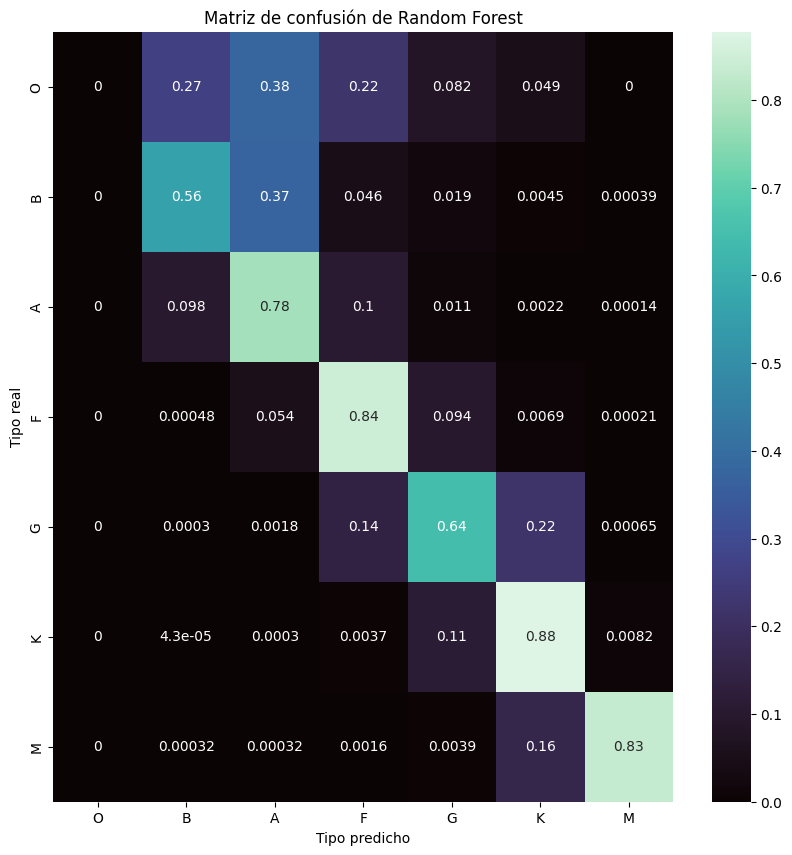

In [70]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, predicted, normalize='true', labels=tipos_espectrales), columns=tipos_espectrales, index=tipos_espectrales)
_, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax=ax, cmap=sns.color_palette("mako", as_cmap=True))
ax.set_ylabel("Tipo real")
ax.set_xlabel("Tipo predicho")
ax.set_title("Matriz de confusión de Random Forest")

In [27]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predicted)

print(report)

              precision    recall  f1-score   support

           A       0.73      0.80      0.76     13927
           B       0.78      0.54      0.63      7776
           F       0.79      0.85      0.82     18935
           G       0.69      0.65      0.67     16887
           K       0.83      0.87      0.85     23484
           M       0.93      0.83      0.87      3098
           O       0.00      0.00      0.00       184

    accuracy                           0.77     84291
   macro avg       0.68      0.65      0.66     84291
weighted avg       0.77      0.77      0.77     84291



# Modelo: Gradient Boosting

https://www.datacamp.com/tutorial/guide-to-the-gradient-boosting-algorithm

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [40]:
params = {  'min_samples_split' : int(split),
            'min_samples_leaf' : int(split/10),
            'max_depth' : 6,
            'max_features' : 'sqrt',
            'subsample' : 0.8
}

gradient_boosting = GradientBoostingClassifier(**params)

grid_search = GridSearchCV(gradient_boosting, param_grid = { 'n_estimators': range(15, 81, 10) }, n_jobs=4, cv=5)

grid_search.fit(x_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=6,
                                                  max_features='sqrt',
                                                  min_samples_leaf=84,
                                                  min_samples_split=842,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'n_estimators': range(15, 81, 10)})

In [63]:
print("Precisión en primera etapa de tuneo: ", grid_search.score(x_test, y_test))

# La segunda etapa de tuneo no se realiza, porque se demora más de 40 minutos y la precisión no sube mucho más.

Precisión en primera etapa de tuneo:  0.774578543379483


Text(0.5, 1.0, 'Matriz de confusión de Gradient Boosting')

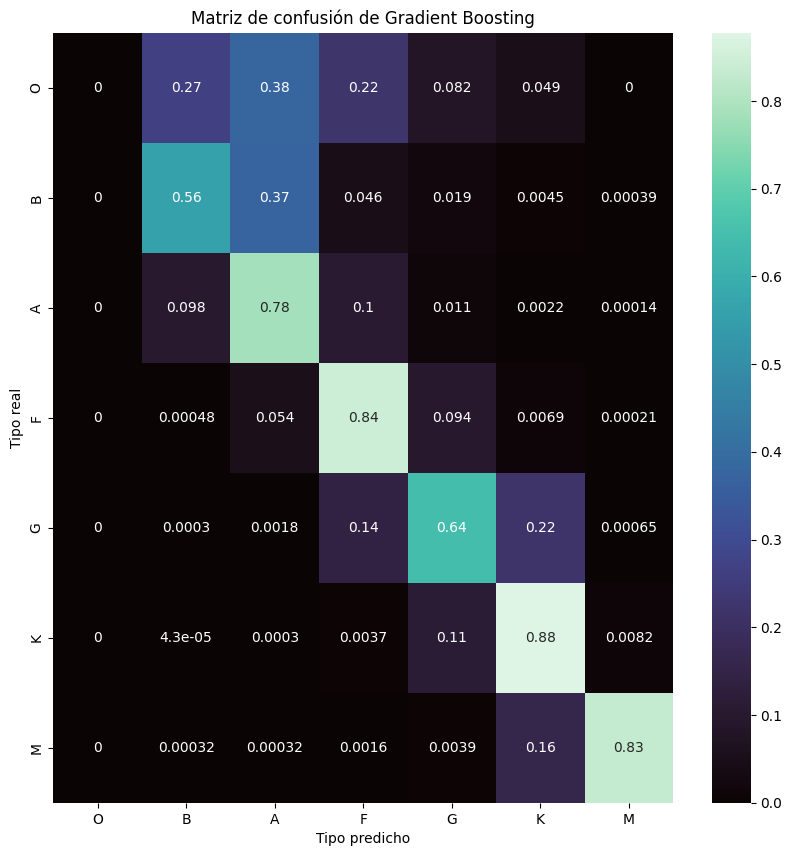

In [68]:
predicted = grid_search.predict(x_test)

cm = pd.DataFrame(confusion_matrix(y_test, predicted, normalize='true', labels=tipos_espectrales), columns=tipos_espectrales, index=tipos_espectrales)
_, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax=ax, cmap=sns.color_palette("mako", as_cmap=True))
ax.set_ylabel("Tipo real")
ax.set_xlabel("Tipo predicho")
ax.set_title("Matriz de confusión de Gradient Boosting")

In [66]:
report = classification_report(y_test, predicted)

print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           A       0.73      0.78      0.76     13927
           B       0.75      0.56      0.64      7776
           F       0.79      0.84      0.82     18935
           G       0.70      0.64      0.67     16887
           K       0.83      0.88      0.85     23484
           M       0.92      0.83      0.88      3098
           O       0.00      0.00      0.00       184

    accuracy                           0.77     84291
   macro avg       0.67      0.65      0.66     84291
weighted avg       0.77      0.77      0.77     84291



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Modelo: K-Vecinos más cercanos

In [71]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score

k_values = [i for i in range (1,50)]
scores = []

for k in k_values:
    classifier = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(classifier, x_train, y_train.values.ravel(), cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Precisión')

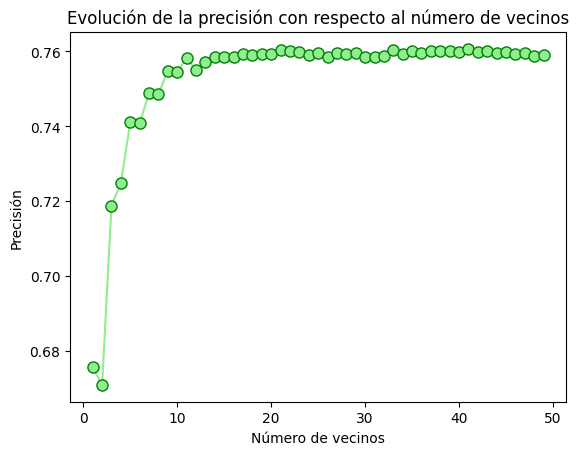

In [75]:
plt.plot(k_values, scores, marker = 'o', color='lightgreen', ms=8, mec='g')
plt.title("Evolución de la precisión con respecto al número de vecinos")
plt.xlabel("Número de vecinos")
plt.ylabel("Precisión")

In [76]:
best_k = k_values[np.argmax(scores)]
print(best_k)

41


In [77]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=41)

In [78]:
knn.score(x_test, y_test)

0.7633911093711072

In [79]:
predicted = knn.predict(x_test)

Text(0.5, 1.0, 'Matriz de confusión de K-Vecinos más cercanos')

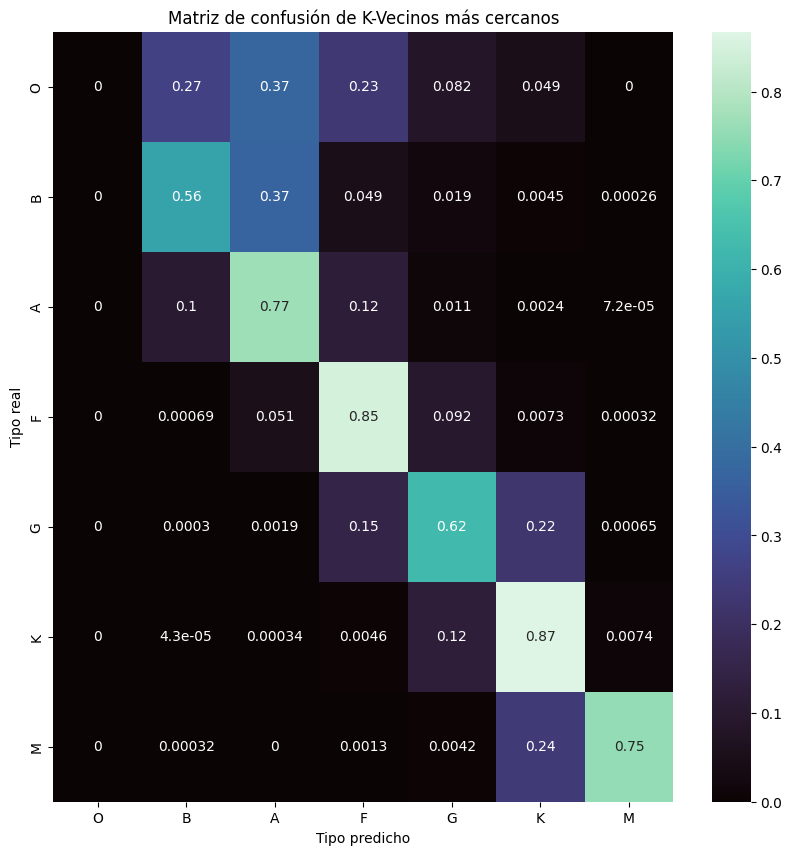

In [82]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted, normalize='true', labels=tipos_espectrales), columns=tipos_espectrales, index=tipos_espectrales)
_, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax=ax, cmap=sns.color_palette("mako", as_cmap=True))
ax.set_ylabel("Tipo real")
ax.set_xlabel("Tipo predicho")
ax.set_title("Matriz de confusión de K-Vecinos más cercanos")

In [81]:
report = classification_report(y_test, predicted)

print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           A       0.73      0.77      0.75     13927
           B       0.74      0.56      0.64      7776
           F       0.77      0.85      0.81     18935
           G       0.68      0.62      0.65     16887
           K       0.81      0.87      0.84     23484
           M       0.92      0.75      0.83      3098
           O       0.00      0.00      0.00       184

    accuracy                           0.76     84291
   macro avg       0.67      0.63      0.65     84291
weighted avg       0.76      0.76      0.76     84291



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Modelo: Red Neuronal

Referencia: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data